# Task 1
Design a quantum circuit that considers as input the following vector of integers numbers:
[1,5,7,10]
<br>
returns a quantum state which is a superposition of indices of the target solution, obtaining in
the output the indices of the inputs where two adjacent bits will always have different values. In
this case the output should be: $\frac{1}{\sqrt{2}}\cdot(|01\rangle + |11\rangle)$, as the correct indices are 1 and 3.

1 = 0001<br>
**5 = 0101**<br>
7 = 0111<br>
**10 = 1010**<br>

<h4>Context</h4>

If you’re struggling to find a proper way to solve this task, you can find some suggestions for a
possible solution below. This is one way to approach the problem, but other solutions may be
feasible as well, so feel free to also investigate different strategies if you see fit!

The key to this task is to use the superposition offered by quantum computing to load all the
values of the input array on a single quantum state, and then locate the values that meet the
target condition. So, how can we use a quantum computer to store multiple values? A possible
solution is using the QRAM (some references: https://arxiv.org/pdf/0708.1879.pdf,
https://github.com/qsharp-community/qram/blob/master/docs/primer.pdf).

As with classical computers, in the QRAM information is accessed using a set of bits indicating
the address of the memory cell, and another set for the actual data stored in the array.
For example, if you want to use a QRAM to store 2 numbers that have most have 3 bits, it can
be achieved with 1 qubit of address and 3 qubits of data.

Suppose you have the vector input_2 = [2,7].
In a properly constructed circuit, when the value of the address qubit is |0> the data qubits have
value 010 (binary representation of 2) and when it is |1> in the data qubits have value 111
(binary representation of 7).

Given such a structure, you should be able to use Grover’s algorithm in order to obtain the
solution to the task.

You can assume that the input always contains at least two numbers that have alternating
bitstrings.

Bonus:

Design a general circuit that accepts vectors with random values of size 2^n with m bits in
length for each element and finds the state(s) indicated above from an oracle.

In [2]:
# import block

import numpy as np
from qiskit import *
from qiskit.quantum_info import Statevector
from qiskit.visualization import *

In [3]:
# Circuit executer functions
def run_circuit_on_sim(qc):
    sim = Aer.get_backend('qasm_simulator')
    result = execute(qc, backend=sim, shots=2048).result()
    return result.get_counts(qc)


## Initiating qRam 

In [4]:
def find_all(s:str, ch:str)-> list: 
    assert ch!='' and s !=''
    
    return [len(s)-i-1 for i in range(len(s)) if ch ==s[i]] 

def qram_encoder(vec: list, index_bit_count, data_bit_count):
    
#     vec_dict = {bin(vec[i])[2:].zfill(data_bit_count): bin(i)[2:].zfill(index_bit_count) for i in range(len(vec))}
    #debugginng
#     print(vec_dict)
    
    index_reg = QuantumRegister(index_bit_count)
    data_reg = QuantumRegister(data_bit_count)
    qc = QuantumCircuit(data_reg, index_reg)
    
    for i in range(len(vec)):
        v = bin(i)[2:].zfill(index_bit_count)
        k = bin(vec[i])[2:].zfill(data_bit_count)
        ones_indices_in_index_reg = find_all(v, '1')
        zeros_indices_in_data_reg = find_all(k, '0')
        
        if len(ones_indices_in_index_reg) > 0:
            #debugging
#             qc.barrier()
            for index in ones_indices_in_index_reg:
                if len(zeros_indices_in_data_reg) >0:
                    qc.x(zeros_indices_in_data_reg)
                qc.mct(data_reg,index_reg[index] )
            
                if len(zeros_indices_in_data_reg) >0:
                    qc.x(zeros_indices_in_data_reg)
            
 
    return qc
    

# vec = [1,5,7,10]
# # vec = [1,10,6,5,7,5,11,3]
# l = len(vec)
# index_bit_count =  int(np.floor(np.log2(l))) # works for any vector of size 2^n
# data_bit_count =  int(np.floor(np.log2(max(vec))) +1) # finding m
    
# qram_encoder(vec, index_bit_count, data_bit_count).draw('mpl')


## Creating Superpostion of two alternating bit pattern

In [5]:
def create_alternate_bit_pattern(n:int):
    qc = QuantumCircuit(n)
    qc.h(0)
    
    for i in range(2, n, 2):
        qc.cx(0, i)
    
    qc.x(0)
    for i in range(1, n, 2):
        qc.cx(0, i)
    qc.x(0)
    return qc

# qc_alt_bit = create_alternate_bit_pattern(4)
# qc_alt_bit.measure_all()
# qc_alt_bit.draw('mpl')

    

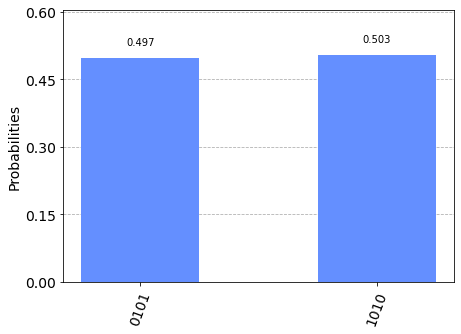

In [21]:
# counts = run_circuit_on_sim(qc_alt_bit)

# plot_histogram(counts)

## Combining all of the above.... 

In [6]:
def task1(vec:list):
    l = len(vec)
    index_bit_count =  int(np.floor(np.log2(l))) # works for any vector of size 2^n
    data_bit_count =  int(np.floor(np.log2(max(vec))) +1) # finding m
    
    index_reg = QuantumRegister(index_bit_count, "index_reg")
    data_reg = QuantumRegister(data_bit_count,"data_reg")
    readout_reg = ClassicalRegister(index_bit_count, 'readout')
    
    qc = QuantumCircuit(data_reg, index_reg, readout_reg)
    
    alternator = create_alternate_bit_pattern(data_bit_count).to_gate(label = "Alternator")
    qram = qram_encoder(vec, index_bit_count, data_bit_count).to_gate(label = "qRam")
    
    qc.append(alternator, data_reg)
    qc.barrier()
    qc.append(qram, range(index_bit_count+ data_bit_count))
    
    qc.measure(index_reg, readout_reg)
    
    return qc
    
    
# vec = [1,5,7,10]
vec = [1,5,4,2]

# vec = [1,10,7,6,5,11,9,3]
circ = task1(vec)
# circ.decompose().draw('mpl')

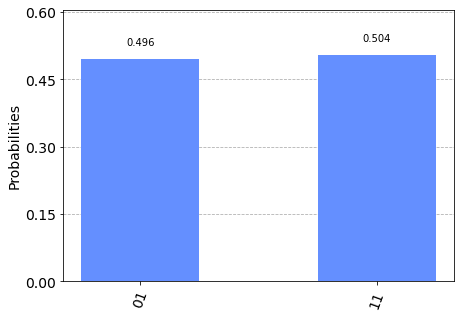

In [7]:
c = run_circuit_on_sim(circ)
plot_histogram(c)